# Recommendations with IBM

In this notebook, I will evaluate the articles that users interacted with on the IBM Watson Studio platform and then make recommendations for them to read new articles. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

In [2]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import project_tests as t
import pickle

%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv') # Import the user item interactions dataframe
df_content = pd.read_csv('data/articles_community.csv') # Import the articles database dataframe
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
df.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [4]:
# Show df_content to get an idea of the data
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>


Let us look at the distribution of articles that users interacts with.  

In [8]:
df_email = df.set_index('email') # Set index to the email 
df_email_count = df_email.groupby('email')['article_id'].count() 
# Group articles by email and extract article_id's count: this gives 
# the number of articles each user interacted with 
df_email_countunique = df_email.groupby('email')['article_id'].unique()
# Here, we define a dataframe as above BUT we include an article in 
# the count only once even if a user has interacted multiple times with it

df_email_count.describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: article_id, dtype: float64

In [10]:
df_email_countunique_len = df_email_countunique.apply(lambda x: len(x)) 
# We extract the number of articles each user interacted with and 
# show the statistics below
df_email_countunique_len.describe()

count    5148.000000
mean        6.540210
std         9.990676
min         1.000000
25%         1.000000
50%         3.000000
75%         7.000000
max       135.000000
Name: article_id, dtype: float64

`2.` Here we explore and remove any duplicate articles from the **df_content** dataframe.  

In [13]:
# Find and explore duplicate articles

df_content[df_content['article_id'].duplicated() == True]
# The above shows the duplicate entries



,doc_body,doc_description,doc_full_name,doc_status,article_id
365,Follow Sign in / Sign up Home About Insight Da...,During the seven-week Insight Data Engineering...,Graph-based machine learning,Live,50
692,Homepage Follow Sign in / Sign up Homepage * H...,One of the earliest documented catalogs was co...,How smart catalogs can turn the big data flood...,Live,221
761,Homepage Follow Sign in Get started Homepage *...,Today’s world of data science leverages data f...,Using Apache Spark as a parallel processing fr...,Live,398
970,This video shows you how to construct queries ...,This video shows you how to construct queries ...,Use the Primary Index,Live,577
971,Homepage Follow Sign in Get started * Home\r\n...,"If you are like most data scientists, you are ...",Self-service data preparation with IBM Data Re...,Live,232


In [15]:
# Remove any rows that have the same article_id - only keep the first


df_content1 = df_content.drop_duplicates(subset =['article_id'])
df_content1.head()


,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


Here will look at some stats:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values) <br>
**d.** The number of user-article interactions in the dataset.

In [18]:
df4 = df.set_index('article_id')
df5 = df4.groupby('article_id')['title']
df4.describe()

,title,email
count,45993,45976
unique,714,5148
top,use deep learning for image classification,2b6c0f514c2f2b04ad3c4583407dccd0810469ee
freq,937,364


In [20]:
unique_articles = 714# The number of unique articles that have at least one interaction
total_articles = 1051 # The number of unique articles on the IBM platform
unique_users = 5148 # The number of unique users
user_article_interactions = 45993 # The number of user-article interactions

I'm curious about what was the most viewed **article_id**, as well as how often it was viewed.

In [23]:
df_id_art = df4.groupby(['article_id']) # Create a dataframe grouped
# by article_id and having the index of article_id

value_counts = df['article_id'].value_counts(dropna=True, sort=True)
# Create a value_count series with number of times the article is 
# interacted with. Then sort it with highest count values on the top.
value_counts.head()

article_id
1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: count, dtype: int64

In [25]:
most_viewed_article_id = '1429.0' # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937 # The most viewed article in the dataset was viewed this many times

In [27]:
## This function will be helpful for later parts of the notebook. It maps the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
df.head()

,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier...",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Since we don't actually have ratings for whether a user liked an article or not, we can assume that the popularity of an article is based on how often an article was interacted with.

Let us define a few functions to get the ids and names of the top `n` articles. These would be the articles we would recommend to a user if we were to use rank-based recommendation.

In [30]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    value_counts = df['article_id'].value_counts(dropna=True, sort=True)
    top_articles_id = list(value_counts.index[0:n])
    # Return articles with highest value counts i.e. interacted with the most
    top_articles = [df[df['article_id'] == art_id].title.iloc[0] for art_id in top_articles_id]
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article ids 
    
    '''
    # Return article ids with highest value counts i.e. interacted with the most
    value_counts = df['article_id'].value_counts(dropna=True, sort=True)
    top_articles = list(value_counts.index[0:n])
    return top_articles # Return the top article ids

In [32]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429.0, 1330.0, 1431.0, 1427.0, 1364.0, 1314.0, 1293.0, 1170.0, 1162.0, 1304.0]


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


To recommend articles to a user based on other users similar to them, let us define a few functions. We can reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once and each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then we place a 1 where the user-row meets for that article-column**.  

* **If a user has not interacted with an item, then we place a zero where the user-row meets for that article-column**. 

In [37]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Extract only the user_id and article_id columns
    
    df6 = df[['user_id', 'article_id']]
    # Extract dummies of the article_id variable and concatenate with user_id variable
    df7 = pd.concat([df6.user_id, pd.get_dummies(df6.article_id)], axis=1)

    # If an article is interacted with more than or equal to once by a user, set it to 1!
    user_item = (df7.groupby('user_id').sum() > 0).astype(int)
    
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

Now we write a function to take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar). The similarity is based on dot product.

In [41]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    sim = user_item.dot(user_item.iloc[user_id-1,:])
    # sort by similarity
    sim2 = sim.sort_values(ascending = False)
    # create list of just the ids
    most_similar_users = list(sim2.index)
    # remove the own user's id
    most_similar_users.remove(user_id)
    
    return most_similar_users # return a list of the users in order from most to least similar
        

In [43]:
# Let's check our function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 131, 3870, 4201, 46, 49]
The 5 most similar users to user 3933 are: [1, 3782, 23, 203, 4459]
The 3 most similar users to user 46 are: [4201, 23, 3782]


Now we can use this function (that provides the most similar users to each user), to find articles you can recommend.  Let's define a few functions.

In [46]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    # Extract titles given the article_ids
    article_names = [df.title[df.article_id == float(a)].iloc[0] for a in article_ids]
    return article_names # Return the article names associated with list of article ids


def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the doc_full_name column in df_content)
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # Extract the articles seen by a user
    article_ids = list(str(x) for x in set(df[df.user_id==user_id].article_id))
    article_names = list(str(x) for x in set(df[df.user_id==user_id].title))
    return article_ids, article_names # return the ids and names


def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Find similar users (by dot product)
    similar_users = find_similar_users(user_id)
    #Find articles already seen by user
    art_ids1, art_nms1 = get_user_articles(user_id)
    
    # Find other articles based on similar users that our user has not 
    # already seen
    rec_list = []
    for user in similar_users:
        art_ids, art_nms = get_user_articles(user)
        rec_list.append(list(set(art_ids) - set(art_ids1)))
    recs2 = [item for sublist in rec_list for item in sublist]
    recs = recs2[:m]
    return recs # return your recommendations for this user_id    

In [48]:
# Let's check the above functions. And get 10 results for user 1.
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1


['simple graphing with ipython and\xa0pandas',
 'using github for project control in dsx',
 'challenges in deep learning',
 'model bike sharing data with spss',
 'i am not a data scientist – ibm watson data lab',
 'data science platforms are on the rise and ibm is leading the way',
 '520    using notebooks with pixiedust for fast, flexi...\nName: title, dtype: object',
 'use decision optimization to schedule league games',
 'machine learning exercises in python, part 1',
 'shaping data with ibm data refinery']

Now we are going to improve the above recommendations.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user, weill instead choose the users that have the most total article interactions before choosing those with fewer article interactions.

* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, we will choose articles with the articles with the most total interactions before choosing those with fewer total interactions. We will use the ranking from the **top_articles** function we wrote earlier.

In [52]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by the user - if a u
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
     
    '''
    
    # To compute number of interactions:
    # Extract dummies of the article_id variable and concatenate with user_id variable
    df_new = pd.concat([df.user_id, pd.get_dummies(df.article_id)], axis=1)

    # Sum the number of interactions of a user
    user_item2 = (df_new.groupby('user_id').sum()).sum(axis=1)
    
    
    # Find the users with most similarity and create a new data frame
    neighbors_df = pd.DataFrame(find_similar_users(user_id), columns = ['neighbor_id'])

    # Add columns with the similarities and their number of interactions
    neighbors_df['similarity'] = list(user_item.loc[neighbors_df.neighbor_id].dot(user_item.loc[user_id,:]))

    
    

    neighbors_df['num_interactions']=list(user_item2.loc[neighbors_df.neighbor_id])

    neighbors_df.sort_values(by=['similarity','num_interactions'], ascending = False)
    
    return neighbors_df # Return the dataframe specified in the doc_string


def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Get the neighbours
    neighbors_df = get_top_sorted_users(user_id)
    # And the articles that our user has already seen
    art_ids1, art_nms1 = get_user_articles(user_id)
    rec_list = []
    
    # Get recommendations from neighbours that our user hasn't already seen
    for user in neighbors_df.neighbor_id:
        art_ids, art_nms = get_user_articles(user)
        rec_list.append(list(set(art_ids) - set(art_ids1)))
        recs2 = [item for sublist in rec_list for item in sublist]
        recs = recs2[:m]
    rec_names = get_article_names(recs)
    return recs, rec_names

In [54]:
neighbors_df = get_top_sorted_users(131)
neighbors_df.iloc[0:12]


,neighbor_id,similarity,num_interactions
0,3870,74,144
1,3782,39,363
2,23,38,364
3,203,33,160
4,4459,33,158
5,49,29,147
6,98,29,170
7,3697,29,145
8,3764,29,169
9,242,25,148


The above method however only works by finding other similar users, so user-bsed collaborative methods will not work. We could use rank based recommendations i.e. the get_top_articles function. For better ways to make recommendations, we could potentially add filters that the user could use to select articles. 

Using these existing functions, here are the top 10 recommended articles for a new user below. 

In [57]:
new_user = '0.0'

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = list(str(x) for x in get_top_article_ids(10)) # Your recommendations here

new_user_recs

['1429.0',
 '1330.0',
 '1431.0',
 '1427.0',
 '1364.0',
 '1314.0',
 '1293.0',
 '1170.0',
 '1162.0',
 '1304.0']

### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations </a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  Content could be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

Here, we define a function to create a content based recommender.  

In [60]:
def make_content_recs(article_id, m):
    '''
    INPUT: 
    article_id - (str with a number) one article id that the user has interacted with
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    For the given article_id, find the users who have interacted with this article. Find the other articles that
    most of these users have interacted with. 

    '''
    article_id_float = float(article_id)
    
    # Find all users who have interacted with this article
    users_df = user_item[user_item.columns[user_item.columns == article_id_float]]
    users_to_use = list(users_df.index[users_df[article_id_float] ==1])
    
    # Find the other articles that they have most interacted with as a group
    articles_rec = user_item.iloc[users_to_use,:].sum().sort_values(ascending= False)
    articles_rec.drop(labels=article_id_float)
    recs = list(str(x) for x in articles_rec[0:m].index)
    rec_names = get_article_names(recs)
    
    return recs, rec_names
    

Now, we can make some recommendations.

In [63]:
# make recommendations for a brand new user
new_user_recs = list(str(x) for x in get_top_article_ids(10)) # Your recommendations here

new_user_recs

# make a recommendations for a user who only has interacted with article id '1427.0'

user_rec_ids, user_rec_titles = make_content_recs('1427.0', 5)

user_rec_ids

['1330.0', '1429.0', '1427.0', '1364.0', '1314.0']

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</a>

In this part of the notebook, we will use use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

In [68]:
# quick look at the matrix
user_item.head()

,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1442.0,1443.0,1444.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perform SVD, and explain why this is different than in the lesson.

In [70]:
# Perform SVD on the User-Item Matrix Here

u, s, vt = np.linalg.svd(user_item)# use the built in to get the three matrices

This matrix has only binary values, so it is different in that sense from the rating matrix used in the lesson. This matrix has nonempty values for every cell, therefore we need not use FunkSVD on it but can do with SVD.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


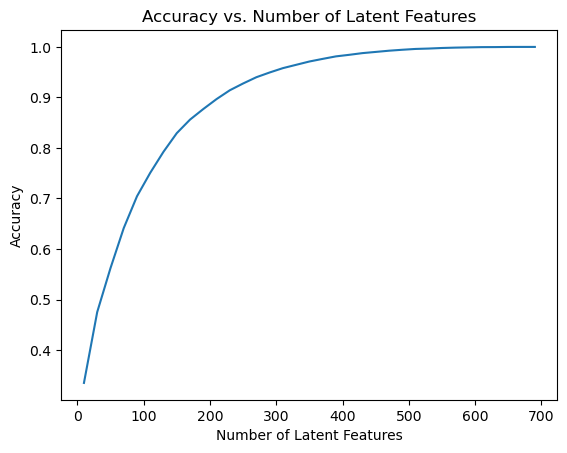

In [72]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [74]:
df_train = df.head(40000)
df_test = df.tail(5993)


# Create matrices for training and testing separately
user_item_train = create_user_item_matrix(df_train)
user_item_test = create_user_item_matrix(df_test)

# Find users in test that are not in train and articles in test that are not in train
len(set(user_item_test.index) - set(user_item_train.index))
len(set(user_item_test.columns) - set(user_item_train.columns))

#Visualize the test matrix
user_item_test.head()

,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1432.0,1433.0,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1443.0
user_id,,,,,,,,,,,,,,,,,,,,,
2917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3024,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3093,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3193,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Create train and test dataframes
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    
    test_idx = list(user_item_test.index)
    test_arts = list(user_item_test.columns)
    
    return user_item_train, user_item_test, test_idx, test_arts

user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

Now, we use the **user_item_train** dataset from above to find U, S, and V transpose using SVD. Then we will find the subset of rows in the **user_item_test** dataset that we can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. 

In [79]:
# fit SVD on the user_item_train matrix
u_train, s_train, vt_train = np.linalg.svd(user_item_train)# fit svd similar to above then use the cells below

# Print all the shapes for understanding what the matrices represent
print(np.shape(u_train))
print(np.shape(s_train))
print(np.shape(vt_train))
print(np.shape(user_item_train))

(4487, 4487)
(714,)
(714, 714)
(4487, 714)


In [81]:
# Find users that are common in the train and test dataframe
rows_to_remove = list(set(user_item_test.index) - set(user_item_train.index))
rows_to_keep = list(set(user_item_test.index) - set(rows_to_remove))
rows_to_keep

# Find article_ids that are common in the train and test dataframe
columns_to_remove = list(set(user_item_test.columns) - set(user_item_train.columns))
columns_to_keep = list(set(user_item_test.columns) - set(columns_to_remove))

# Find row indices correponding to common users
# and column indices correponsing to common article_ids
users_to_keep = [row - 1 for row in rows_to_keep]
article_indices = list(user_item_train.columns)
articles_to_keep = [article_indices.index(i) for i in columns_to_keep]


# Find the u_train, v_train and s_train corresponding to only common users
# and articles

u_train2 = u_train[users_to_keep,:]
u_train3 = u_train2[:, users_to_keep]
vt_train2 = vt_train[articles_to_keep,:]
vt_train3 = vt_train2[:, articles_to_keep]
s_train2 = s_train[articles_to_keep]
np.shape(np.around(np.dot(np.dot(u_new, s_new), vt_new)))



# Keep only the common users in the train and test dataframes; 
# we keep all the articles as they are all present in the train dataframe
user_item_test2 = user_item_test.loc[user_item_test.index.intersection(rows_to_keep)]



/opt/anaconda3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


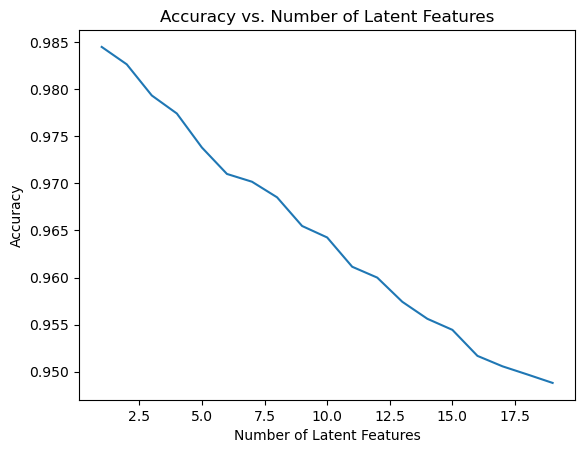

In [83]:
# Use the reduced u,v,s to make predictions about the test dataframe
# with different number of latent features and compare the results

num_latent_feats = np.arange(1,20,1)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s_train2[:k]), u_train3[:, :k], vt_train3[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_test2, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

It seems that the accuracy on the test set is high but that it reduced with the number of latent features. This could be because as the number of latent features increases, the model overfits on the training data to reproduce the training data matrix. 

To determine if any of the above recommendation systems are an improvement, we could perhaps perform cross validation on the dataset but splitting it into train-test groups multiple times and then averaging over the prediction accuracies.

To evaluate the performance of the recommendation system, we could do an A/B testing type experiment where we recommend articles to the users based on our predictions and see if they're morely like to follow up on these articles compared to articles that were not predicted.